Output point = Threshold(Sum (Input image * Kernel) ^2)



dose 3개, defocus 3개 -> 총 9 set
ex) n_n : dose (-), defocus (-) / nom_p: dose (nominal), defocus (+)

setting   | threshold
----------|---------
n_n     | 0.179974	 
n_nom   | 0.469374
n_p | 0.473029
nom_n	| 0.179974
nom_nom | 0.469374
nom_p	| 0.473029
p_n	| 0.468841
p_nom	| 0.469374
p_p	| 0.176808

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/_Lithography/exp
%ls

/content/drive/.shortcut-targets-by-id/1-cDjEscMqUB_ILBaHskGEdSLL0TiJKD3/exp
'Kernel 9set'/  'Layout 100'/


In [3]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from scipy import signal
from PIL import Image, ImageOps

Layout size:  (2000, 2000)


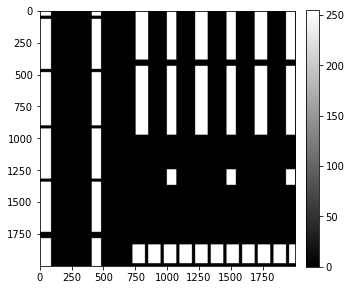

In [4]:
sample_layout = np.array(Image.open("./Layout 100/clipped_25_17x11+9.png"))
print("Layout size: ", sample_layout.shape)
plt.figure(figsize=(5,5))
plt.imshow(sample_layout, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)

kernel size:  (1024, 1024, 4)


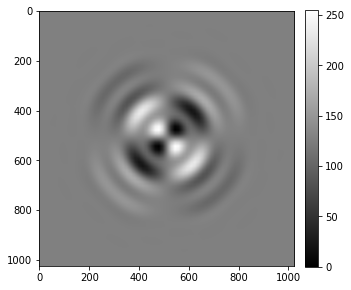

In [5]:
sample_kernel = np.array(Image.open("./Kernel 9set/n_n/11.png"))
print("kernel size: ", sample_kernel.shape)
plt.figure(figsize=(5,5))
plt.imshow(sample_kernel, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)

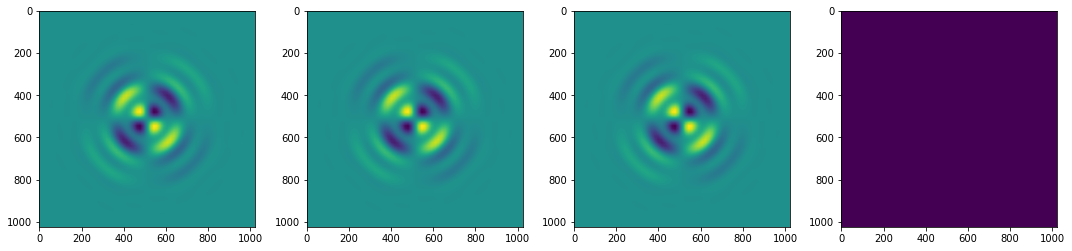

In [6]:
plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(sample_kernel[:,:,i])
plt.tight_layout()
# maybe saved as RGB + alpha format --> should be imported as grayscale

kernel size:  (1024, 1024)


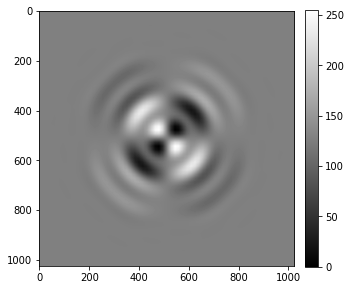

In [7]:
# need to convert to grayscale first
sample_kernel = np.array(ImageOps.grayscale(Image.open("./Kernel 9set/n_n/11.png")))
print("kernel size: ", sample_kernel.shape)
plt.figure(figsize=(5,5))
plt.imshow(sample_kernel, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)

(977, 977)


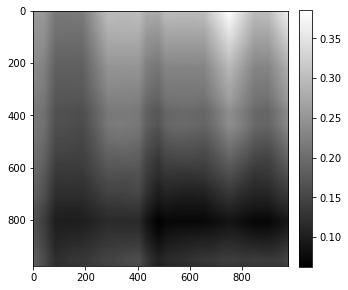

In [8]:
# normalize
layout_norm = sample_layout.astype('float64') / np.max(sample_layout)
kernel_norm = sample_kernel.astype('float64') / np.sum(sample_kernel) # normalize kernel sum to 1

# convolve test
img_blur = signal.fftconvolve(layout_norm, kernel_norm, mode='valid') # other option 'same', 'full'
# note: speed when GPU or not// scipy.signal.fftconvolve vs torch.nn.Conv2d 
print(img_blur.shape)
plt.figure(figsize=(5,5))
plt.imshow(img_blur, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)

In [9]:
# Generate kernel stack
param_type = 'n_n'
print(glob.glob("./Kernel 9set/{}/*.png".format(param_type)))

['./Kernel 9set/n_n/0.png', './Kernel 9set/n_n/2.png', './Kernel 9set/n_n/1.png', './Kernel 9set/n_n/3.png', './Kernel 9set/n_n/6.png', './Kernel 9set/n_n/4.png', './Kernel 9set/n_n/7.png', './Kernel 9set/n_n/5.png', './Kernel 9set/n_n/11.png', './Kernel 9set/n_n/9.png', './Kernel 9set/n_n/8.png', './Kernel 9set/n_n/10.png', './Kernel 9set/n_n/14.png', './Kernel 9set/n_n/15.png', './Kernel 9set/n_n/12.png', './Kernel 9set/n_n/13.png', './Kernel 9set/n_n/16.png', './Kernel 9set/n_n/17.png', './Kernel 9set/n_n/18.png', './Kernel 9set/n_n/19.png', './Kernel 9set/n_n/22.png', './Kernel 9set/n_n/21.png', './Kernel 9set/n_n/20.png', './Kernel 9set/n_n/24.png', './Kernel 9set/n_n/23.png', './Kernel 9set/n_n/25.png', './Kernel 9set/n_n/27.png', './Kernel 9set/n_n/26.png', './Kernel 9set/n_n/28.png', './Kernel 9set/n_n/29.png']


In [10]:
kernel_n_n = np.zeros((1024,1024,30), dtype=np.float64)
for i, path in enumerate(glob.glob("./Kernel 9set/{}/*.png".format(param_type))):
  kernel = np.array(ImageOps.grayscale(Image.open(path)))
  kernel = kernel.astype('float64') / np.sum(kernel)
  kernel_n_n[:,:,i] = kernel

In [12]:
np.sum(kernel_n_n)

29.99999999999995

In [15]:
# conv and sum
def conv_sqr_sum(img, kernels, coeffs):
  ''' img: input image,
      kernels: list of kernels (1024x1024x30)
      coeffs: eigenvalues '''
  
  output = np.zeros((img.shape[0]-kernels.shape[0]+1, img.shape[1]-kernels.shape[1]+1))
  for i in range(kernels.shape[-1]):
    kernel = kernels[:,:,i]
    output += coeffs[i]*signal.fftconvolve(img, kernel, mode='valid')**2
  return output

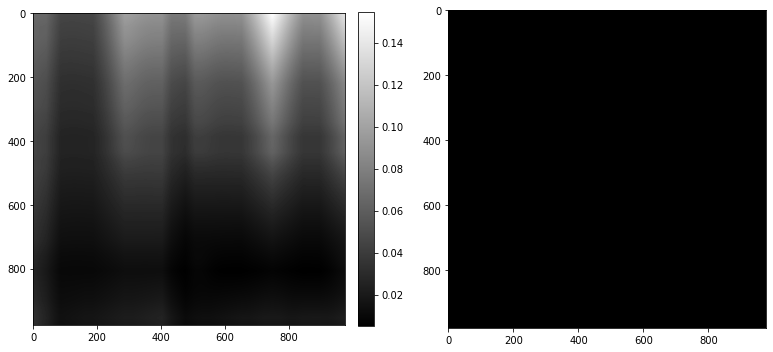

In [16]:
# when uniform eigenvalues
coeffs = np.array([1./30]*30)
result = conv_sqr_sum(layout_norm, kernel_n_n, coeffs)

plt.figure(figsize=(11,5))
plt.subplot(121)
plt.imshow(result, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(result > 0.179974, cmap='gray') 
plt.tight_layout()

[8.21673285e-01 1.46526298e-01 2.61295535e-02 4.65959744e-03
 8.30930707e-04 1.48177144e-04 2.64239434e-05 4.71209503e-06
 8.40292430e-07 1.49846589e-07 2.67216500e-08 4.76518408e-09
 8.49759626e-10 1.51534843e-10 2.70227108e-11 4.81887127e-12
 8.59333485e-13 1.53242118e-13 2.73271635e-14 4.87316332e-15
 8.69015208e-16 1.54968628e-16 2.76350464e-17 4.92806706e-18
 8.78806011e-19 1.56714590e-19 2.79463980e-20 4.98358937e-21
 8.88707123e-22 1.58480222e-22]


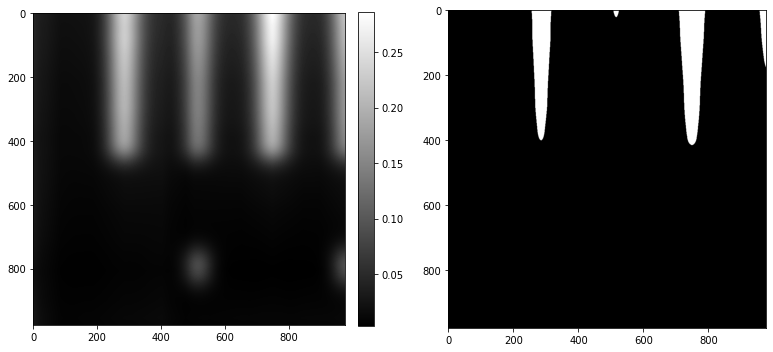

In [22]:
# exponentially decaying eigenvalue
coeff_exp = np.exp(-np.linspace(0,5,30)*10)
coeff_exp /= coeff_exp.sum()
print(coeff_exp)

result = conv_sqr_sum(layout_norm, kernel_n_n, coeff_exp)

plt.figure(figsize=(11,5))
plt.subplot(121)
plt.imshow(result, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(result > 0.179974, cmap='gray') 
plt.tight_layout()

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


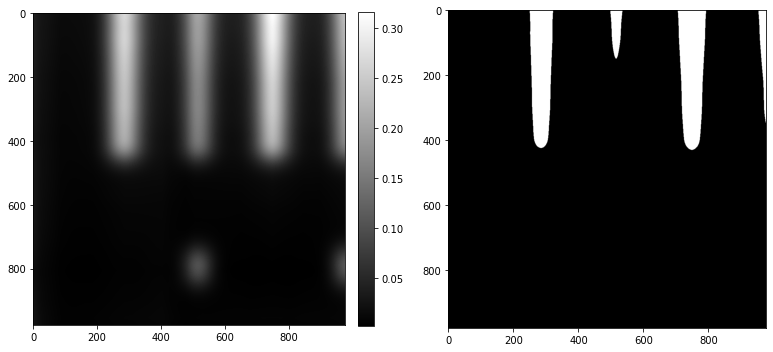

In [23]:
# only first kernel
coeff_one = [1] + [0]*29
print(coeff_one)

result = conv_sqr_sum(layout_norm, kernel_n_n, coeff_one)

plt.figure(figsize=(11,5))
plt.subplot(121)
plt.imshow(result, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(result > 0.179974, cmap='gray') 
plt.tight_layout()